#### Imports

In [1]:
import os
import re
import json

import numpy as np
import pandas as pd
import networkx as nx
import plotly.express as px
from unidecode import unidecode
from matplotlib import pyplot as plt

#### Configurating default behavior

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

In [3]:
db_path = './data/universidade_federal_do_rio_grande_do_norte_-_ufrn'

#### Auxiliar functions

In [4]:
db_resources = [p for p in os.listdir(db_path)]

resources_containing = lambda sw: [os.path.join(db_path,r) for r in db_resources if sw in r and r.endswith('.csv')]
dataframe_containing = lambda sw : pd.concat([pd.read_csv(csv, sep=';',decimal=',') for csv in resources_containing(sw)])

#### Loading curricular data

In [5]:
compontentes = dataframe_containing("componentes-curriculares")
estruturas_curriculares = dataframe_containing('estruturas-curriculares')
estruturas_curriculares_componentes = dataframe_containing('curriculo-componente')

#### Filtering curricular data

In [6]:
id_valid_year = estruturas_curriculares['ano_entrada_vigor']!=0

id_estruturas_curriculares = id_valid_year

estruturas_curriculares = estruturas_curriculares[id_estruturas_curriculares]

In [7]:
id_valid_curricula = estruturas_curriculares_componentes['id_curriculo'].isin(estruturas_curriculares['id_curriculo'])
id_valid_component = estruturas_curriculares_componentes['id_componente_curricular'].isin(compontentes['id_componente'])

id_estruturas_curriculares_componentes = id_valid_curricula & id_valid_component

estruturas_curriculares_componentes = estruturas_curriculares_componentes[id_estruturas_curriculares_componentes]

In [8]:
id_graduacao = compontentes['nivel'] == "G"

id_componentes = np.array([True]*len(compontentes))
# id_componentes = id_componentes & id_graduacao))))

compontentes = compontentes[id_componentes]

#### Transforming data

##### Requirement tree

In [9]:
compontentes['equivalencia'] = compontentes['equivalencia'].apply(lambda x: x.strip(' ') if type(x) == str else '(  )')
compontentes['co_requisito'] = compontentes['co_requisito'].apply(lambda x: x.strip(' ') if type(x) == str else '(  )')
compontentes['pre_requisito'] = compontentes['pre_requisito'].apply(lambda x: x.strip(' ') if type(x) == str else '(  )')

In [10]:
id_component_invalid = compontentes['pre_requisito'].apply(lambda x: len(re.findall(r'\b[^\.](\d+)',x)) > 0)

In [11]:
for x in compontentes[id_component_invalid].iloc:
    id_componentes = [int(x) for x in x['pre_requisito'].strip('( )').split()]
    comp = compontentes[compontentes['id_componente'].isin(id_componentes)]
    
    pre_requisito = '( ( ' + ' ) E ( '.join(comp['codigo'].values) + ' ) )'
    
    compontentes.loc[compontentes['id_componente'] == x['id_componente'],'pre_requisito'] = pre_requisito

### Filtering

In [12]:
all_compontentes = compontentes.copy()
all_estruturas_curriculares = estruturas_curriculares.copy()
all_estruturas_curriculares_componentes = estruturas_curriculares_componentes.copy()

In [13]:
patterns =['cien.*comp','tecno.*info','eng.*sof']
id = [False] * all_estruturas_curriculares.shape[0]
for pattern in patterns:
    id = id | all_estruturas_curriculares['nome_curso'].apply(lambda nome:  len(re.findall(pattern,unidecode(nome.lower())))!=0).values
estruturas_curriculares = all_estruturas_curriculares[id]

In [14]:
estruturas_curriculares_componentes = all_estruturas_curriculares_componentes[all_estruturas_curriculares_componentes['id_curriculo'].isin(estruturas_curriculares['id_curriculo'])]
estruturas_curriculares = estruturas_curriculares[estruturas_curriculares['id_curriculo'].isin(estruturas_curriculares_componentes['id_curriculo'])]
estruturas_curriculares = estruturas_curriculares[estruturas_curriculares['nome_matriz'].apply(lambda nm: not nm is np.nan)]

## Analysing DIMAP/IMD data

In [15]:
estrutura_curricular = estruturas_curriculares.iloc[0]
estrutura_curricular

id_curriculo                                                            134044403
codigo                                                                         02
nome_matriz                     TECNOLOGIA DA INFORMAÇÃO - NATAL - MT - BACHAR...
id_curso                                                                 92127264
nome_curso                                               TECNOLOGIA DA INFORMAÇÃO
semestre_conclusao_minimo                                                     7.0
semestre_conclusao_ideal                                                      7.0
semestre_conclusao_maximo                                                    10.0
meses_conclusao_minimo                                                        NaN
meses_conclusao_ideal                                                         NaN
meses_conclusao_maximo                                                        NaN
cr_total_minimo                                                                26
ch_total_minima 

In [16]:
estrutura_curricular_componentes_info = estruturas_curriculares_componentes[estruturas_curriculares_componentes['id_curriculo'] == estrutura_curricular['id_curriculo']]
estrutura_curricular_componentes_info = estrutura_curricular_componentes_info.merge(compontentes, left_on='id_componente_curricular', right_on='id_componente')
estrutura_curricular_componentes_info = estrutura_curricular_componentes_info.merge(estruturas_curriculares, left_on='id_curriculo', right_on='id_curriculo')

In [17]:
from itertools import chain

In [18]:
estrutura_curricular_codigo_componentes = set(estrutura_curricular_componentes_info['codigo_x'].values)

estrutura_curricular_codigo_componentes.update(set(chain(*estrutura_curricular_componentes_info['equivalencia'].apply(lambda x: re.findall(r'\w+\d+',x) if type(x) == str else []).values)))
estrutura_curricular_codigo_componentes.update(set(chain(*estrutura_curricular_componentes_info['co_requisito'].apply(lambda x: re.findall(r'\w+\d+',x) if type(x) == str else []).values)))
estrutura_curricular_codigo_componentes.update(set(chain(*estrutura_curricular_componentes_info['pre_requisito'].apply(lambda x: re.findall(r'\w+\d+',x) if type(x) == str else []).values)))

In [19]:
estrutura_curricular_componentes = compontentes[compontentes['codigo'].isin(estrutura_curricular_codigo_componentes)]

In [20]:
estrutura_curricular_componentes_info['tipo_vinculo_componente'].unique()

array(['OBRIGATÓRIO', 'OPTATIVO'], dtype=object)

In [21]:
a = estrutura_curricular_componentes_info[estrutura_curricular_componentes_info['tipo_vinculo_componente'] == 'OBRIGATÓRIO']

In [22]:
[print(e) for e in re.findall('([^\(\)]+)',pr)];

NameError: name 'pr' is not defined

In [34]:
a['equivalencia'].apply(lambda x: (x,re.sub('\s*\(?\s*(\w+\d+)\s*\)\s*',r' ( \1 ) ',x)))

0      (IMD0019 OU MAT3023 OU MAT0372, IMD0019 OU MAT...
2      (( DIM0111 ) OU ( IMD0035 ) OU ( DIM0116 ),  (...
23     (( IMD0037 OU ECT1307 OU ECT2305 ), ( IMD0037 ...
32     (( IMD0016 OU ECT1105 OU ECT2105 ), ( IMD0016 ...
37     (( ECT1112 E ECT1211 ) OU ( ECT2102 ) OU ( MAT...
45     (( DIM0108 ) OU ( IMD1000 ) OU ( DIM0118 ) OU ...
50                                    (IMD0019, IMD0019)
65     (( IMD0404 ) OU ( DIM0543 ) OU ( DIM0513 ),  (...
66     (( DIM0444 ) OU ( DIM0502 ),  ( DIM0444 ) OU (...
69                                          ((  ), (  ))
76     (( DIM0110 ) OU ( IMD0025 ) OU ( DIM0120 ),  (...
102    (( IMD0026 OU ECT1205 OU ECT2205 ), ( IMD0026 ...
104    (DIM0132 OU EST0322 OU ( EST0032 E EST0033 ) O...
113                                         ((  ), (  ))
114    (( DIM0111 ) OU ( IMD0032 ) OU ( DIM0117 ),  (...
118                         (( DIM0419 ),  ( DIM0419 ) )
126    (( IMD0013 OU DIM0400 OU DIM0115 ), ( IMD0013 ...
127    (( DIM0600 ) OU ( DIM050

In [26]:
[(eq,re.findall('([^\(\)]+)',eq)) for eq in a['equivalencia'].iloc]

[('IMD0019 OU MAT3023 OU MAT0372', ['IMD0019 OU MAT3023 OU MAT0372']),
 ('( DIM0111 ) OU ( IMD0035 ) OU ( DIM0116 )',
  [' DIM0111 ', ' OU ', ' IMD0035 ', ' OU ', ' DIM0116 ']),
 ('( IMD0037 OU ECT1307 OU ECT2305 )', [' IMD0037 OU ECT1307 OU ECT2305 ']),
 ('( IMD0016 OU ECT1105 OU ECT2105 )', [' IMD0016 OU ECT1105 OU ECT2105 ']),
 ('( ECT1112 E ECT1211 ) OU ( ECT2102 ) OU ( MAT0230 )',
  [' ECT1112 E ECT1211 ', ' OU ', ' ECT2102 ', ' OU ', ' MAT0230 ']),
 ('( DIM0108 ) OU ( IMD1000 ) OU ( DIM0118 ) OU IMD1012 OU DIM0133',
  [' DIM0108 ',
   ' OU ',
   ' IMD1000 ',
   ' OU ',
   ' DIM0118 ',
   ' OU IMD1012 OU DIM0133']),
 ('IMD0019', ['IMD0019']),
 ('( IMD0404 ) OU ( DIM0543 ) OU ( DIM0513 )',
  [' IMD0404 ', ' OU ', ' DIM0543 ', ' OU ', ' DIM0513 ']),
 ('( DIM0444 ) OU ( DIM0502 )', [' DIM0444 ', ' OU ', ' DIM0502 ']),
 ('(  )', ['  ']),
 ('( DIM0110 ) OU ( IMD0025 ) OU ( DIM0120 )',
  [' DIM0110 ', ' OU ', ' IMD0025 ', ' OU ', ' DIM0120 ']),
 ('( IMD0026 OU ECT1205 OU ECT2205 )', [' 

In [24]:
for eq in a['equivalencia'].iloc:
    print(eq,re.findall('[^\( \)]+',eq))
    print(eq,re.findall('([^\(\)]+)',eq))

IMD0019 OU MAT3023 OU MAT0372 ['IMD0019', 'OU', 'MAT3023', 'OU', 'MAT0372']
IMD0019 OU MAT3023 OU MAT0372 ['IMD0019 OU MAT3023 OU MAT0372']
( DIM0111 ) OU ( IMD0035 ) OU ( DIM0116 ) ['DIM0111', 'OU', 'IMD0035', 'OU', 'DIM0116']
( DIM0111 ) OU ( IMD0035 ) OU ( DIM0116 ) [' DIM0111 ', ' OU ', ' IMD0035 ', ' OU ', ' DIM0116 ']
( IMD0037 OU ECT1307 OU ECT2305 ) ['IMD0037', 'OU', 'ECT1307', 'OU', 'ECT2305']
( IMD0037 OU ECT1307 OU ECT2305 ) [' IMD0037 OU ECT1307 OU ECT2305 ']
( IMD0016 OU ECT1105 OU ECT2105 ) ['IMD0016', 'OU', 'ECT1105', 'OU', 'ECT2105']
( IMD0016 OU ECT1105 OU ECT2105 ) [' IMD0016 OU ECT1105 OU ECT2105 ']
( ECT1112 E ECT1211 ) OU ( ECT2102 ) OU ( MAT0230 ) ['ECT1112', 'E', 'ECT1211', 'OU', 'ECT2102', 'OU', 'MAT0230']
( ECT1112 E ECT1211 ) OU ( ECT2102 ) OU ( MAT0230 ) [' ECT1112 E ECT1211 ', ' OU ', ' ECT2102 ', ' OU ', ' MAT0230 ']
( DIM0108 ) OU ( IMD1000 ) OU ( DIM0118 ) OU IMD1012 OU DIM0133 ['DIM0108', 'OU', 'IMD1000', 'OU', 'DIM0118', 'OU', 'IMD1012', 'OU', 'DIM0133'

['DIM0432', 'OU', 'DCA0108', 'OU', 'DIM0615', 'OU', 'IMD0042', 'OU', 'DIM0131']

In [35]:
a

id_curriculo_componente  id_curriculo  id_componente_curricular  semestre_oferta tipo_vinculo_componente nivel_ensino  id_componente  \
0                  134045126     134044403                     66436                1             OBRIGATÓRIO    GRADUAÇÃO          66436   
2                  134044644     134044403                     55027                4             OBRIGATÓRIO    GRADUAÇÃO          55027   
23                 134044635     134044403                     55020                1             OBRIGATÓRIO    GRADUAÇÃO          55020   
32                 134044634     134044403                     55019                1             OBRIGATÓRIO    GRADUAÇÃO          55019   
37                 134044580     134044403                     52665                2             OBRIGATÓRIO    GRADUAÇÃO          52665   
45                 134044638     134044403                     52650                2             OBRIGATÓRIO    GRADUAÇÃO          52650   
50                 134045125     134044403                     66441                1             OBRIGATÓRIO    GRADUAÇÃO          66441   
65                 134044650     134044403                     52867                5             OBRIGATÓRIO    GRADUAÇÃO          52867   
66                 134045135     134044403                     55371                7             OBRIGATÓRIO    GRADUAÇÃO          55371   
69                 134044649     134044403                   2054911                5             OBRIGATÓRIO    GRADUAÇÃO        2054911   
76                 134044582     134044403                     55024                3             OBRIGATÓRIO    GRADUAÇÃO          55024   
102                134044578     134044403                     55021                2             OBRIGATÓRIO    GRADUAÇÃO          55021   
104                134044583     134044403                     52664                3             OBRIGATÓRIO    GRADUAÇÃO          52664   
113                134044642     134044403                   2054912                4             OBRIGATÓRIO    GRADUAÇÃO        2054912   
114                134044643     134044403                     55026                4             OBRIGATÓRIO    GRADUAÇÃO          55026   
118                134044588     134044403                   2054919                7             OBRIGATÓRIO    GRADUAÇÃO        2054919   
126                134044579     134044403                     55022                2             OBRIGATÓRIO    GRADUAÇÃO          55022   
127                134044648     134044403                     69698                5             OBRIGATÓRIO    GRADUAÇÃO          69698   
137                134044639     134044403                     55025                3             OBRIGATÓRIO    GRADUAÇÃO          55025   
141                134045128     134044403                     66440                1             OBRIGATÓRIO    GRADUAÇÃO          66440   
150                134044584     134044403                     52870                6             OBRIGATÓRIO    GRADUAÇÃO          52870   
155                134044587     134044403                   2054914                7             OBRIGATÓRIO    GRADUAÇÃO        2054914   
161                134045134     134044403                     66373                6             OBRIGATÓRIO    GRADUAÇÃO          66373   
173                134044651     134044403                     52866                5             OBRIGATÓRIO    GRADUAÇÃO          52866   
196                134045131     134044403                   2054904                4             OBRIGATÓRIO    GRADUAÇÃO        2054904   
201                134044637     134044403                     55082                1             OBRIGATÓRIO    GRADUAÇÃO          55082   
206                134045127     134044403                     66438                1             OBRIGATÓRIO    GRADUAÇÃO          66438   
207                134045129     134044403               

In [20]:
id_ecc_wo_equivalence = estrutura_curricular_componentes['equivalencia'].apply(lambda x: x =='(  )')
id_ecc_wo_requirement = estrutura_curricular_componentes['pre_requisito'].apply(lambda x: x =='(  )')
id_ecc_wo_corequirement = estrutura_curricular_componentes['co_requisito'].apply(lambda x: x =='(  )')

id_ecc = id_ecc_wo_equivalence & id_ecc_wo_requirement & id_ecc_wo_corequirement

In [ ]:
compontentes = compontentes[(compontentes['unidade_responsavel'] == 'INSTITUTO METROPOLE DIGITAL') | (compontentes['unidade_responsavel'] == 'DEPARTAMENTO DE INFORMÁTICA E MATEMÁTICA APLICADA')]
compontentes = compontentes[['id_componente','codigo','nome','ch_total']]

In [32]:
turmas = dataframe_containing("turma")

turmas = turmas[turmas['nivel_ensino'] == 'GRADUAÇÃO']
turmas = turmas[turmas['situacao_turma'] == 'CONSOLIDADA']
turmas = turmas[turmas['id_componente_curricular'].isin(compontentes['id_componente'])]
turmas.data_consolidacao = pd.to_datetime(turmas.data_consolidacao)

turmas = turmas[['id_turma','siape','id_componente_curricular','ch_dedicada_periodo','descricao_horario','data_consolidacao']]
turmas['ano'] = [d.year for d in turmas.data_consolidacao]
turmas = turmas.dropna()

In [7]:
matriculas = dataframe_containing("matricula")

matriculas.drop(['unidade','nota','reposicao','faltas_unidade'], axis=1, inplace=True)
matriculas = matriculas[matriculas['id_turma'].isin(turmas['id_turma'])]

matricula_id_descricao = { k:v for k,v in enumerate(matriculas['descricao'].unique()) }
matricula_descricao_id = { v:k for k,v in enumerate(matriculas['descricao'].unique()) }

matriculas['descricao'] = matriculas['descricao'].map(matricula_descricao_id)
matriculas = matriculas[matriculas['media_final'] != 0]
matriculas = matriculas.drop_duplicates()

In [8]:
cursos = dataframe_containing('cursos-ufrn')
cursos = cursos[cursos['id_curso'].isin(matriculas['id_curso'])]
cursos = cursos[['id_curso','nome']]

In [9]:
import plotly.express as px

In [23]:
px.histogram(matriculas, x='media_final', nbins=100,width=800)

In [33]:
turmas

id_turma      siape  id_componente_curricular  ch_dedicada_periodo  \
2385  57547356   347031.0                     23499                   90   
2387  57547358   346444.0                     23499                   90   
2389  57547360   346444.0                     23499                   30   
2390  57547360   347031.0                     23499                   60   
2394  57547364   346444.0                     21704                   90   
...        ...        ...                       ...                  ...   
4952   1163801  1862439.0                     21747                   45   
8055   1166877  2497950.0                   2022858                   30   
9373   1167957  1363515.0                     21781                   60   
9375   1167959  2177445.0                     21772                   60   
9463   1168029  1859562.0                     21785                   60   

     descricao_horario       data_consolidacao     ano  
2385            246T34 2010-07-06 10:25:56.834  2010.0  
2387            246N34 2010-07-01 15:20:47.662  2010.0  
2389            246M56 2010-07-01 15:16:45.846  2010.0  
2390            246M56 2010-07-01 15:16:45.846  2010.0  
2394            246T56 2010-07-01 15:15:13.723  2010.0  
...                ...                     ...     ...  
4952             35M56 2011-07-15 12:39:15.198  2011.0  
8055              4T56 2011-07-15 10:23:05.047  2011.0  
9373             35T12 2011-07-14 11:18:04.962  2011.0  
9375             24N12 2011-07-15 23:19:13.098  2011.0  
9463             35M34 2011-07-12 18:49:56.429  2011.0  

[4011 rows x 7 columns]

In [26]:
px.histogram(matriculas, y='descricao',width=800)

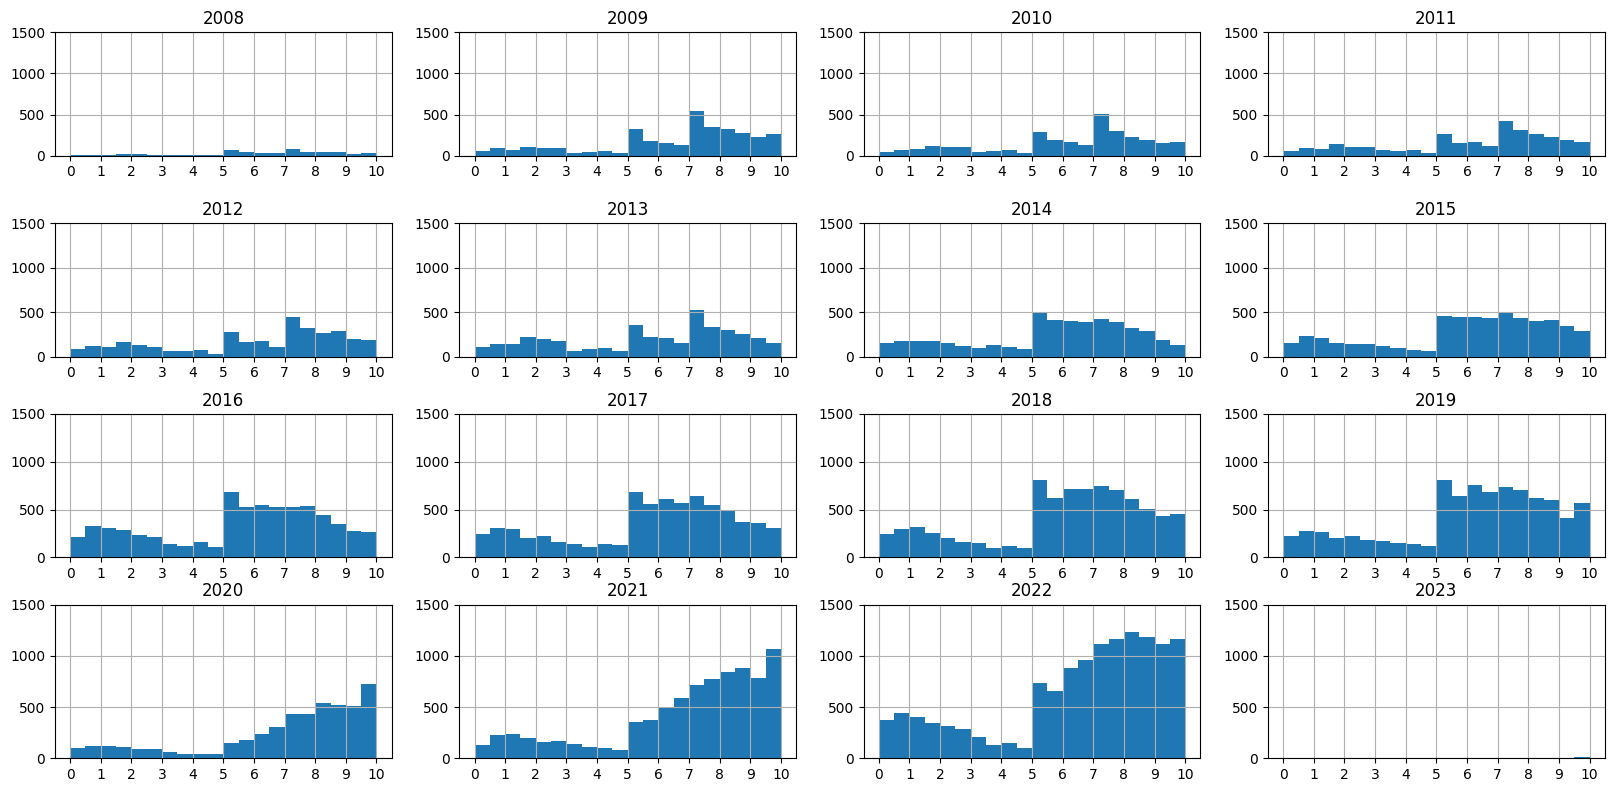

In [19]:
plt.subplots(4,4,figsize=(20,10))
c = 0
for g,gg in turmas.groupby('ano'):
    c+=1
    ax = plt.subplot(4,4,c)
    plt.hist(matriculas[matriculas['id_turma'].isin(gg.id_turma)].media_final,bins=np.arange(0,10.5,.5));
    plt.title(int(g))
    plt.ylim(0,1500)
    plt.xticks(np.arange(0,10.5,1))
    plt.grid(True)
    pos = ax.get_position()
    pos.y1 = pos.y1*.95
    ax.set_position(pos)
    
    

In [20]:
df = matriculas.merge(turmas, on='id_turma', how='right')
df.rename(columns={'id_componente_curricular':'id_componente'}, inplace=True)
df = df.merge(compontentes, on='id_componente', how='left')
df = df.dropna()
df = df.drop_duplicates()
df['ano'] = df['ano'].astype(int)
df['descricao_horario'] = [' '.join(re.findall('[2-7]+[MTN][1-6]+',h)) for h in df['descricao_horario']]

In [23]:
df.sample(4).T

13295  \
id_turma                                      1233661   
discente             e2f6cedf3e234ec1aff642a1e4fd3f9a   
id_curso                                    2000013.0   
media_final                                       2.1   
numero_total_faltas                              18.0   
descricao                                         4.0   
id_componente                                 2054912   
ch_dedicada_periodo                                60   
descricao_horario                               35T12   
data_consolidacao          2014-12-12 20:53:18.836000   
ano                                              2014   
codigo                                        DIM0508   
nome                 PROJETO DE INTERFACES DE USUÁRIO   
ch_total                                           60   

                                                66589  \
id_turma                                     57628452   
discente             55422ff94179b9d146b1e66c3b6ace5a   
id_curso                                   92127264.0   
media_final                                       5.0   
numero_total_faltas                               0.0   
descricao                                        11.0   
id_componente                                   66438   
ch_dedicada_periodo                                30   
descricao_horario                                3N34   
data_consolidacao          2018-12-22 01:01:09.167000   
ano                                              2018   
codigo                                        IMD1003   
nome                             GEOMETRIA EUCLIDIANA   
ch_total                                           30   

                                                            26405  \
id_turma                                                  1200764   
discente                         947a95b130e8847eab831a0528fd4404   
id_curso                                                2000013.0   
media_final                                                   7.8   
numero_total_faltas                                           0.0   
descricao                                                     0.0   
id_componente                                               52657   
ch_dedicada_periodo                                            45   
descricao_horario                                            6M12   
data_consolidacao                      2013-06-29 13:49:20.517000   
ano                                                          2013   
codigo                                                    IMD0016   
nome                 PRÁTICAS DE LEITURA E ESCRITA EM PORTUGUÊS I   
ch_total                                                       45   

                                                95530  
id_turma                                     57677903  
discente             728899ab75d1fd537f636857a8c48203  
id_curso                                   92127264.0  
media_final                                       2.3  
numero_total_faltas                              44.0  
descricao                                         4.0  
id_componente                                   55023  
ch_dedicada_periodo                                60  
descricao_horario                               35T34  
data_consolidacao          2021-09-14 10:54:47.767000  
ano                                              2021  
codigo                                        IMD0029  
nome                     ESTRUTURA DE DADOS BÁSICAS I  
ch_total                                           60

In [31]:
from itertools import product

In [32]:
graphs_by_year = {}
for ano,df_ano in df.groupby(['ano']):
    Graph1 = nx.Graph()
    for codigo,disciplina in df_ano.groupby('codigo'):
        media = disciplina['media_final'].mean()
        mediana = disciplina['media_final'].median()
        Graph1.add_node(codigo, nome=disciplina['nome'].iloc[0], media=media, mediana=mediana)

    for d,discente in df_ano.groupby('discente'):
        A = discente[['codigo','media_final']].values
        for a,b in product(A,A):
            Graph1.add_edge(a[0],b[0],mean=(a[1]+b[1])/2)
    
    graphs_by_year[ano[0]] = Graph1

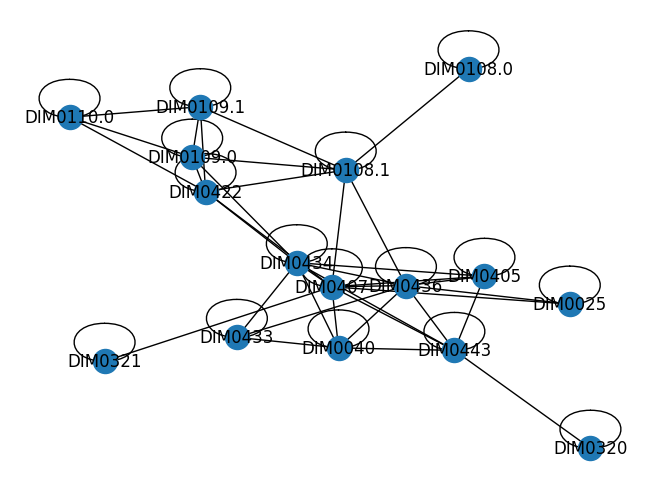

In [33]:
nx.draw(graphs_by_year[2008],with_labels=True)

In [34]:
from pyvis.network import Network

In [35]:
nt = Network('100%', '500px',notebook=True,cdn_resources='in_line')
# populates the nodes and edges data structures
nt.from_nx(graphs_by_year[2009])
nt.barnes_hut()

nt.show_buttons(filter_=['physics'])
nt.show('nx.html')

nx.html


In [20]:
graphs_by_year[2009].nodes(data=True)

NodeDataView({'DIM0021': {'nome': 'SISTEMAS DE INFORMACOES', 'media': 5.74, 'mediana': 5.1, 'size': 10}, 'DIM0025': {'nome': 'RELATORIO DE GRADUACAO', 'media': 8.674999999999999, 'mediana': 8.9, 'size': 10}, 'DIM0040': {'nome': 'CALCULO NUMERICO', 'media': 6.679591836734694, 'mediana': 7.1, 'size': 10}, 'DIM0042': {'nome': 'INTRODUCAO A PROGRAMACAO LINEAR', 'media': 7.514285714285715, 'mediana': 7.1, 'size': 10}, 'DIM0084': {'nome': 'PROGRAMACAO ORIENTADA PARA OBJETOS', 'media': 3.65, 'mediana': 3.65, 'size': 10}, 'DIM0096': {'nome': 'TOPICOS ESPECIAIS EM COMPUTACAO VII', 'media': 7.534999999999999, 'mediana': 7.75, 'size': 10}, 'DIM0098': {'nome': 'TOPICOS ESPECIAIS EM COMPUTACAO IX', 'media': 8.366666666666667, 'mediana': 8.1, 'size': 10}, 'DIM0099': {'nome': 'TOPICOS ESPECIAIS EM COMPUTACAO X', 'media': 8.475, 'mediana': 8.7, 'size': 10}, 'DIM0103': {'nome': 'INTRODUCAO A INFORMATICA', 'media': 7.522506393861893, 'mediana': 7.7, 'size': 10}, 'DIM0104': {'nome': 'SOFTWARES APLICATIVO

In [21]:
graphs_by_year[2009].edges(data=True)

EdgeDataView([('DIM0021', 'DIM0107', {'mean': 8.0, 'width': 1}), ('DIM0021', 'DIM0430', {'mean': 5.0, 'width': 1}), ('DIM0021', 'DIM0437', {'mean': 5.9, 'width': 1}), ('DIM0021', 'DIM0104', {'mean': 6.0, 'width': 1}), ('DIM0021', 'DIM0440', {'mean': 5.05, 'width': 1}), ('DIM0021', 'DIM0442', {'mean': 5.65, 'width': 1}), ('DIM0021', 'DIM0021', {'mean': 5.1, 'width': 1}), ('DIM0021', 'DIM0084', {'mean': 2.65, 'width': 1}), ('DIM0021', 'DIM0310', {'mean': 5.1, 'width': 1}), ('DIM0021', 'DIM0406', {'mean': 6.05, 'width': 1}), ('DIM0021', 'DIM0435', {'mean': 2.8, 'width': 1}), ('DIM0025', 'DIM0406', {'mean': 8.1, 'width': 1}), ('DIM0025', 'DIM0025', {'mean': 9.0, 'width': 1}), ('DIM0025', 'DIM0434', {'mean': 8.0, 'width': 1}), ('DIM0025', 'DIM0420', {'mean': 9.0, 'width': 1}), ('DIM0025', 'DIM0332', {'mean': 8.25, 'width': 1}), ('DIM0040', 'DIM0040', {'mean': 7.9, 'width': 1}), ('DIM0040', 'DIM0320', {'mean': 6.8, 'width': 1}), ('DIM0040', 'DIM0321', {'mean': 8.2, 'width': 1}), ('DIM0040', 